In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import sympy as sp
from sympy import symbols as s
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

%matplotlib widget

graph_path = Path("../images/").resolve()
data_path = Path("../data/").resolve()

plt.style.use("./report.mplstyle")

Variabili

In [ ]:
wave_length = 650 / 10**9

slit_name = 0.02
slit = slit_name / 10**3
slit_pos = 4 / 10**2

sensor_name = 1.5
sensor = sensor_name / 10**3
sensor_pos = 102.5 / 10**2

distance = sensor_pos - slit_pos

Load data

In [ ]:
dfs = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(sensor_name) in file
]

# Scelti mettendo lo 0 a metà tra i primi minimi
dfs[0].y += 0.099
dfs[1].y += 0.099
dfs[2].y += 0.098
dfs[3].y += 0.099

Center sets on 0

(-0.03552703650000001, 1.3842208865)

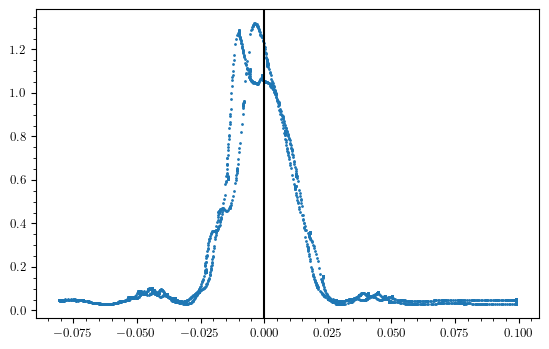

In [ ]:
fig, ax = plt.subplots(1, 1)

df = dfs[3]
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Scatter graph

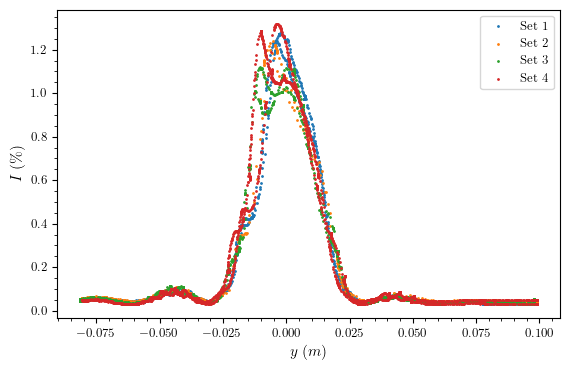

In [ ]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"scatter_{slit_name}.png")

Find minimums

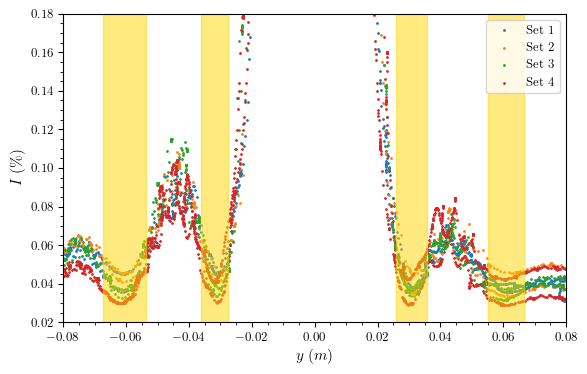

In [ ]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

# minimums = [
#     [-0.0646, -0.0580],
#     [-0.0346, -0.0280],
#     [0.0270, 0.0337],
#     [0.0572, 0.0648],
# ]

minimums = [
    [-0.0675, -0.0538],
    [-0.0362, -0.0275],
    [0.0259, 0.0358],
    [0.0551, 0.0666],
]

ylim = ax.get_ylim()

for minimum in minimums:
    ax.fill_betweenx(ylim, [minimum[0]]*2, [minimum[1]]*2, color="gold", alpha=0.5)

# ax.fill_betweenx(ylim, [-0.0626]*2, [-0.0600]*2, color="gold", alpha=0.5)
# ax.fill_betweenx(ylim, [-0.0326]*2, [-0.0300]*2, color="gold", alpha=0.5)
# ax.fill_betweenx(ylim, [0.0290]*2,   [0.0317]*2, color="gold", alpha=0.5)
# ax.fill_betweenx(ylim, [0.0592]*2,   [0.0628]*2, color="gold", alpha=0.5)
ax.set_ylim(0.02, 0.18)
ax.set_xlim(-0.08, 0.08)

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

fig.savefig(graph_path / f"min_{slit_name}.png")

Fenditura dai minimi

In [ ]:
mins_df = pd.DataFrame({
    'y': [
        abs(min[0] + min[1]) / 2
        for min in minimums
    ],
    'dy': [
        abs(min[0] - min[1]) / 2
        for min in minimums
    ],
})

mins_df['l'] = mins_df.y
mins_df['dl'] = mins_df.dy
mins_df.loc[[0, 3], ['l', 'dl']] /= 2

mins_df['a'] =  mins_df.apply(lambda r: wave_length * distance / r.l, axis=1)
mins_df['da'] =  mins_df.apply(lambda r: np.sqrt(
    (1e-3 / distance)**2 + (r.dl / r.l)**2
) * r.a, axis=1)
mins_df['w'] = mins_df.da.to_numpy()**-2

print(
    np.average(mins_df.a, weights=mins_df.w),
    1 / np.sqrt(np.sum(mins_df.w))
)

pd.options.display.float_format = '{:.10f}'.format
mins_df

2.0830462000651462e-05 1.2388638845820348e-06


,y,dy,l,dl,a,da,w
0,0.0606500000,0.0068500000,0.0303250000,0.0034250000,0.0000211129,0.0000023847,175852206875.6241455078
1,0.0318500000,0.0043500000,0.0318500000,0.0043500000,0.0000201020,0.0000027456,132658799378.3410339355
2,0.0308500000,0.0049500000,0.0308500000,0.0049500000,0.0000207536,0.0000033301,90176570611.3021545410
3,0.0608500000,0.0057500000,0.0304250000,0.0028750000,0.0000210435,0.0000019886,252870023090.1575927734


Fit

In [ ]:
I_expr = s('I_0') * sp.Pow( sp.sinc(
    sp.pi * s('a') / s(r'\lambda') * s('y')/s('L')
), 2) + s('c')

I_fit = sp.lambdify(
    [s('y'), s('I_0'), s('a'), s('c')],
    I_expr.evalf(
        subs = {
            s(r'\lambda'): wave_length,
            s('L'): distance,
        }
    )
)

I_expr

I_0*sinc(pi*a*y/(L*\lambda))**2 + c

Rumore e picco

In [ ]:
I_max = 1
I_min = 1

for df in dfs:
    I_min = df.I.min() if df.I.min() < I_min else I_min
    I_max = df.I.max() if df.I.max() > I_max else I_max

I_max, I_min

(1.31968689, 0.02874756)

In [ ]:
I_fitted, a_fitted, c_fitted = 0, 0, 0
for df in dfs:
    popt, pcov = curve_fit(I_fit, df.y, df.I, [I_max, slit, I_min])
    print(popt, np.sqrt(np.diag(pcov)))
    I_fitted += popt[0]
    a_fitted += popt[1]
    c_fitted += popt[2]

I_fitted /= len(dfs)
a_fitted /= len(dfs)
c_fitted /= len(dfs)

print(I_fitted)
print(a_fitted)
print(c_fitted)

[1.15191521e+00 2.21869228e-05 3.42408132e-02] [3.71957296e-03 7.68783349e-08 1.33143920e-03]
[1.12717349e+00 2.09090176e-05 3.55541905e-02] [7.33751271e-03 1.37268918e-07 2.00715668e-03]
[1.06336525e+00 1.97596915e-05 3.38876513e-02] [4.91716320e-03 9.25751430e-08 1.55524366e-03]
[1.12656500e+00 2.02348249e-05 3.16593309e-02] [4.94710240e-03 9.45020445e-08 1.90421653e-03]
1.117254740391409
2.0772614221187465e-05
0.03383549647043113


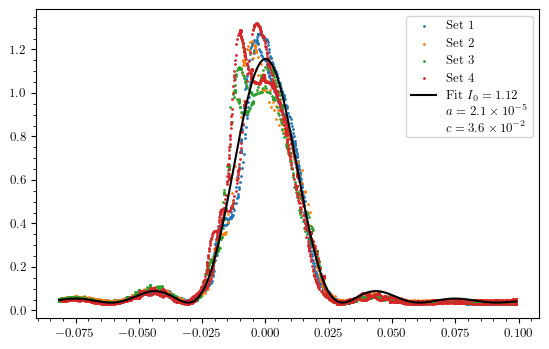

In [ ]:
fig, ax = plt.subplots(1, 1)

for i, df in enumerate(dfs):
    ax.scatter(df.y, df.I, s=1, label=f"Set {i+1}")

x = np.linspace(
    min([
        df.y.min()
        for df in dfs
    ]),
    max([
        df.y.max()
        for df in dfs
    ]),
    1000
)

ax.plot(x, I_fit(x, 1.12, 2.1e-5, 3.6e-2), color="black", label=r"Fit $I_0 = 1.12$ \par $a = 2.1 \times 10^{-5}$ \par $c = 3.6 \times 10^{-2}$")
# ax.plot(x, I_fit(x, I_fitted, a_fitted, c_fitted + 0.002))
# ax.plot(x, I_fit(x, I_fitted + 0.15, a_fitted - 0.2e-5, c_fitted + 0.01))
# ax.plot(x, I_fit(x, I_fitted - 0.15, a_fitted + 0.2e-5, c_fitted - 0.006))

ax.legend()

fig.savefig(graph_path / f"fit_{slit_name}.png")

Scegli il miglior set a 1.5

In [ ]:
df_15 = dfs[0]

df_10 = [
    pd.read_csv(
        data_path / "measure" / file,
        sep="\t",
        engine="python"
    )
    for file in os.listdir(data_path / "measure")
    if str(slit_name) in file and str(1.0) in file
][0]

df_10.y += 0.098

Centrare i nuovi set

(-0.0396911635, 0.9718200735)

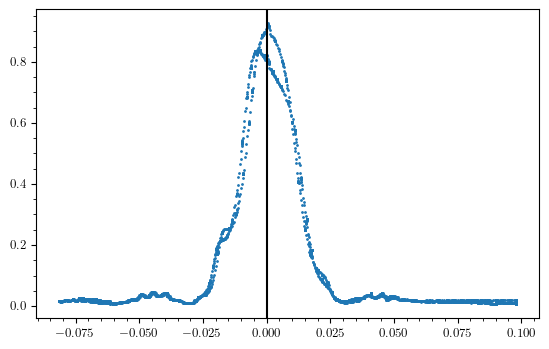

In [ ]:
fig, ax = plt.subplots(1, 1)

df = df_10
ax.scatter(df.y, df.I, s=1)

ylim = ax.get_ylim()
ax.plot([0, 0], ylim, color="black")
ax.set_ylim(ylim)

Confronto sensori

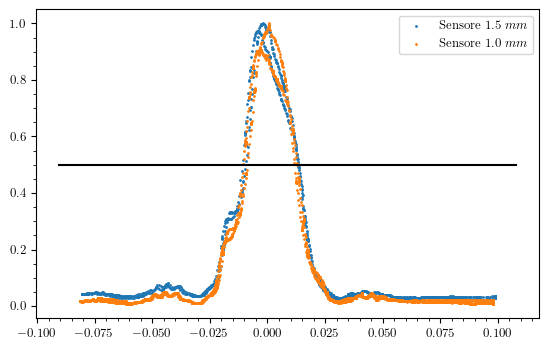

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.scatter(df_15.y, df_15.I / df_15.I.max(), s=1, label=r"Sensore $1.5 \; mm$")
ax.scatter(df_10.y, df_10.I / df_10.I.max(), s=1, label=r"Sensore $1.0 \; mm$")

ax.set_xlabel(r"$y \; (m)$")
ax.set_ylabel(r"$I \; (\%)$")
ax.legend()

zoom = ax.inset_axes([0.6, 0.3, 0.35, 0.45])

zoom.scatter(df_15.y, df_15.I / df_15.I.max(), s=1, label=r"Sensore $1.5 \; mm$")
zoom.scatter(df_10.y, df_10.I / df_10.I.max(), s=1, label=r"Sensore $1.0 \; mm$")

xlim = zoom.get_xlim()
zoom.plot(xlim, [0.5, 0.5], color="black")

zoom.set_xlim(-0.01, 0.01)
zoom.set_ylim(0.4, 0.6)

ax.indicate_inset_zoom(zoom, edgecolor="black")

# fig.savefig(graph_path / f"sensor_{slit_name}.png")